<a href="https://colab.research.google.com/github/yebyyy/Infinite-Shakepear/blob/main/lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Building GPT

First let's download the shakespear text

In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-06-25 19:41:59--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  5.50MB/s    in 0.2s    

2024-06-25 19:42:00 (5.50 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


#### Tokenization

The tokenizer for this project is very simple

In [4]:
charInt = {Char:Int for Int, Char in enumerate(chars)}
intChar = {Int:Char for Int, Char in enumerate(chars)}

In [5]:
def encode(txt):
  li = []
  for chr in txt:
    li.append(charInt.get(chr))
  return li

In [6]:
def decode(intList):
  string = ""
  for i in intList:
    string += intChar[i]
  return string

In [7]:
encode("hello")

[46, 43, 50, 50, 53]

In [8]:
decode(encode("where are you"))

'where are you'

Now tokenize the entire text

In [9]:
import torch

In [10]:
data = torch.tensor(encode(text), dtype=torch.long)

In [11]:
data.shape, data.dtype

(torch.Size([1115394]), torch.int64)

In [12]:
data[:500]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57,  1, 47, 57,  1, 41, 

#### Train test split

In [13]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

#### Chunk(Block) Size

In practice, we don't put all the training data set to the transformer all at once, which would be computationally expensive. So we only use chunks of data to train the transformer.

What we do is we sample random chunks and feed them to the transformer. Each chunk has a maximum length, called `block_size`.

In [14]:
block_size = 8
train_data[ : block_size + 1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

This is how the training works: predicting the next word

In [15]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


This will make the transformer to be able to predict the context length of 1 ~ `block_size`, and more than the maximum length, the text will be truncated

#### Batch Size

Every time we train the transformer, we will train the transfromer using batches with multiple chunks of data, and they are stacked up in a single tensor.

This is because GPUs' parallel processing can boost efficiency.

The chunks in a batch are processed individually and do not correlate with one another.

In [16]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    # stack up the one dimensional tensors, shape is batch_size * block_size
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

#### Simplest Language Model: Bigram

In [17]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

In [18]:
class BigramLanguageModel(nn.Module):
  def __init__(self, vocab_size) -> None:
     super().__init__()
     self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)  # for every token, in this case char, will have a row of vocab_size to represent its embedding vector

  def forward(self, idx, targets=None):
    # Target is none because that when we generate we don't have a target

    logits = self.token_embedding_table(idx)  # (Batch, Time, Channel) -> (4 * 8 * 65)

    if targets is None:
      loss = None
    else:
    # loss = F.cross_entropy(logits, targets)
    # This is what we want but we cannot achieve this since pytorch treats the input as (B, C, T) which is not a very good representation of the data
    # Thus reshape
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx: (B, T) the current context
    for _ in range(max_new_tokens):
      logits, loss = self(idx)
      # only care about the last time step since this is a bigram model
      logits = logits[:, -1, :]  # B, C
      probs = F.softmax(logits, dim=-1)  # B, C
      idx_next = torch.multinomial(probs, num_samples=1)  # B, 1, which means that for every batch get the next token
      # Again, batch means that we have batch_size number of random start points
      idx = torch.cat((idx, idx_next), dim=1)  # B, T+1
    return idx


m = BigramLanguageModel(vocab_size)
out, loss = m(xb, yb)
print(out.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


- -log(1 / 65) = 4.17, so we are actually higher than expected

Generate from the model

In [19]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))  # [0] because its [[]] shape


Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


#### Train the Bigram Model

Create an AdamW optimizer

In [20]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)  # Usually 1e-4, but for small network can be larger

Use a bigger Batch Size

In [21]:
batch_size = 32

In [22]:
for steps in range(10000):
  # sample a batch of data
  xb, yb = get_batch('train')

  # evaluate loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

2.5727508068084717


Generate to see how we doin'

In [23]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=300)[0].tolist()))  # [0] because its [[]] shape


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht 


#### Self Attention Version 1: for loop

Example:

In [24]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

For each token as the target, we cannot let it talk to future tokens, and it can only be paired with the previous tokens. Now, since we are pairing things up, we can average up the previous tokens and pair it with the target token

But this is pretty lossy
- This is not a strong relation
- This also loses information about the position

In [25]:
# We want x[b, t] = mean {i <= t} x[b, i]
xbow = torch.zeros((B, T, C))  # BOW is short for bag of words, which is a term used to describe averaging up words
for b in range(B):
  for t in range(T):
    xprev = x[b, : t + 1]  # (t, C) since we have chosen the batch to be b
    xbow[b, t] = torch.mean(xprev, 0)

In [26]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [27]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

However, this implementation still uses a loop, which is not efficient enough

#### Self Attention Version 2: matrix multiplication

Example of matrix multiplication

In [28]:
torch.manual_seed(42)
a = torch.ones(3, 3)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b
print(a)
print(b)
print(c)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


`torch.tril` returns the lower triangular matrix

In [29]:
torch.tril(torch.ones(3, 3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

Now we can also normalize the torch.tril ones thus to get an average of this
- Remember to set keepdim = True! So that we divide correctly

In [30]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b
print(a)
print(b)
print(c)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


Matrix self attention:

In [31]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

In [32]:
weights = torch.tril(torch.ones(T, T))
weights = weights / weights.sum(1, keepdim=True)
weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

Since weights is of shapa(T, T), torch will automatically make it (B, T, C) when doing matrix multiplication, therefore xbow2 is (B, T, C)

In [33]:
xbow2 = weights @ x  #(T, T) * (B, T, C)
xbow2.shape

torch.Size([4, 8, 2])

#### Self Attention Version 3: adding softmax

In [34]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

In [35]:
tril = torch.tril(torch.ones(T, T))
weights = torch.zeros((T, T))  # sort of telling us the context window: How much past tokens can I look at
weights = weights.masked_fill(tril == 0, float('-inf'))  # dont allow looking at tokens from the future
print(weights)
weights = F.softmax(weights, dim=-1)  # e ^ z / sum(e ^ z), and e^-inf == 0
print(weights)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


#### Most Important: Self Attention Version 4: Self Attention

Making weights all zeros isn't what we really want and need, because some tokens may have higher affinity than others.

Self attention: every single token at each position will emit two vectors: Query Q and Key K. Q: What am I looking for, K: What do I contain. We do dot product between keys and queries in order to get the Affinities between the tokens.

My Q dot product with every other K will be the weights

Value V is like an information matrix of X

In [39]:
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch, time, channels
x = torch.randn(B, T, C)

# implement a single head of self attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)  # (B, T, 16)
q = query(x)  # (B, T, 16)
v = value(x)  # (B, T, 16)

# Now do the dot product, but we cannot directly matrix multiply since the size and intuition is wrong
weights = q @ k.transpose(-2, -1)  # (B, T, 16) * (B, 16, T)  --> (B, T, T), which is exactly (T, T) affinity


tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

out = weights @ v
out.shape

torch.Size([4, 8, 16])

We can see now weights instead of only being constants now it has different weights to different tokens

In [40]:
weights

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

#### Notes

##### Note 1: Attention as communication

Attention is like a directed graph and has T nodes.
- First node is pointed by itself
- Second node is pointed by the first node and itself
- ...
- Until the eighth node
Each node has some vector information and it gets aggregated via a **weighted sum** from all the nodes that points to it

##### Note 2: Attention has no notion over space

Attention just acts on set, and they correlate with each other. If we need them to have a sense of position, we have to give a positional encoding

##### Note 3: Examples don't communicate between batches

##### Note 4: Encoder Block vs Decoder Block

The encoder block of self attention need all tokens to talk to each other, thus dont need to mask

##### Note 5: Attention, Self Attention, and Cross Attention

- Self Attention: Q, K, V are all coming from X, the same source. Self Attention is used when we have nodes that need to talk to each other.
- Cross Attention: Q from X, K, V from external source, and we are producing queries while reading information from the side. And Cross Attention is used when we want to pull information from an external source into our nodes

##### Note 6: Why divide by sqrt(head_size) like in the paper `softmax(QK^T/d_k)V`

If k and q are unit guassian, weights /= sqrt(head_size) will preserve the variance to be 1

In [41]:
K = torch.randn(B, T, head_size)
Q = torch.randn(B, T, head_size)
wei = Q @ K.transpose(-2, -1) * head_size ** -0.5
K.var(), Q.var(), wei.var()

(tensor(1.0449), tensor(1.0700), tensor(1.0918))

Why do we need to preserve the variance?

This is because weights is fed into softmax() function. If the input for a softmax function is diffuses too much, softmax will converge to a one hot vector

In [44]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [45]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]) * 8, dim=-1)

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

When the things fed into softmax gets more negative and more positive, the result will sharpen towards the largest

Especially at initialization, this is not what we want for a node to only take information from another single node

#### Multiheaded Self Attention

Multiheaded Attention is applying attention in parallel and concatenating the result

#### Feedforward process

The feedforward layer is essentially a MLP

#### Block

Attention and Feedforward process, since we are only implementing a decoder, becomes a block that is repeated

The Transformer block intersperses(穿插) the communication(Attention) with the computation(FeedForward)

#### Residual Connections

However, as the deep Neural Network gets deeper since we create Blocks, we start to get into optimization issues like vanishing gradiens and exploding gradients.

The depth of the network can also cause gradients to explode if the factors multiplied during backpropagation are greater than one, and the gradients can diminish exponentially if they are less than one, making it difficult for the weights in the earlier layers to update properly.


Notice that we have a "Add and Norm" Layer in the Attention and Transformer Paper, and that is a **skip connection**, or called **residual connection**

They come from [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385)

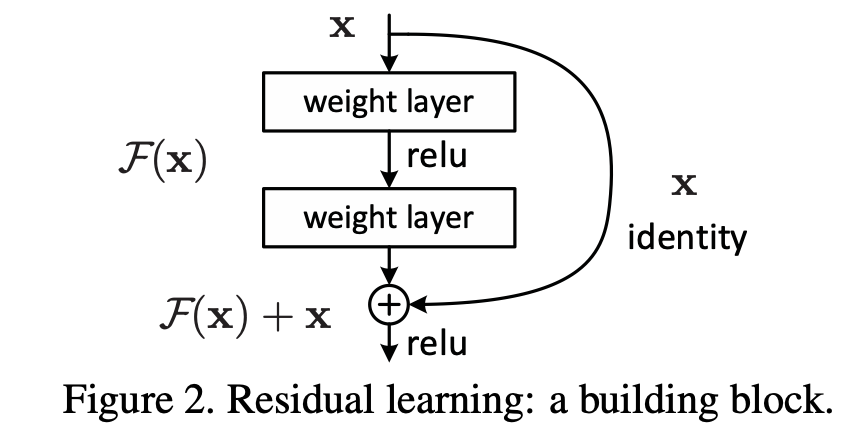

This is called skip connection because we not only transform the data through F(x) but also have a skip connection with addition

After the input we can sort of fork off and perform operations on the input and add it back to in the end

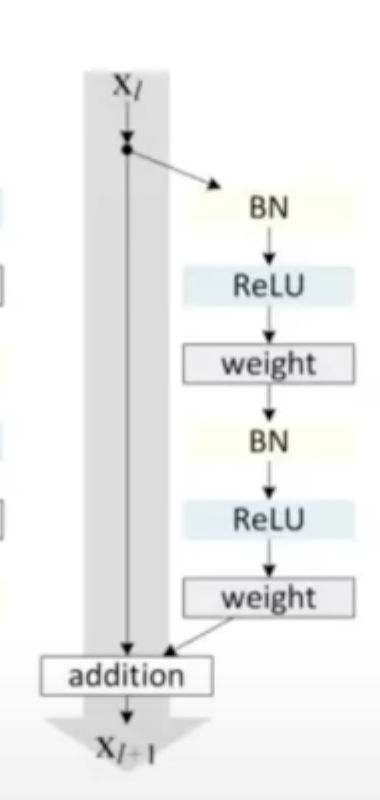

Since during **back propagation**, addition distributes gradients equally to both of the branches.

This means that during backpropagation, the gradients can bypass certain layers, maintaining their magnitude and ensuring that the earlier layers receive meaningful gradient updates.

This direct path prevents gradients from becoming too small (vanishing) or too large (exploding) as they propagate through many layers.

The residual blocks are initialized to contribute less at the start but more as training progresses.

Although not a formal requirement, one implicit design is that at the very start of training, the transformations applied by the residual block (like convolutional or fully connected layers) should be close to the identity function

 This means the layers within the residual block should initially perform minimal transformation. This is typically achieved by initializing the weights in such a way that the output is close to the input when the network starts training.

As the training progresses, the layers within the residual block start to learn useful features. They gradually move away from the identity function and start contributing meaningful transformations. The residual connection still ensures that the original input is combined with these new features, which stabilizes the training process and allows the network to benefit from both the original and learned information.


- Besides the All this, we also add a self projection layer on top of the attention and feedforward block, so that the linear layer is used to retain dimension and introduce further representations, features, and flexibility to represent itself.

#### LayerNorm

Opposite to batch normalization, which normalizes across columns(batches), layer norm normalizes across rows(each individual example)

Also, training and validation will have no distinction, and we don't keep the running buffer

In [1]:
class BatchNorm1D:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    self.gemma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # Forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    # Normalize the layer
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = xhat * self.gemma + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gemma, self.beta]

This is the original Batch Norm layer, and now we change it into Layer Norm by:
- No training or validation difference
- No running mean
- Change mean and var dimension to be 1(across every example)

In [2]:
class LayerNorm:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gemma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # Forward pass
    xmean = x.mean(1, keepdim=True)
    xvar = x.var(1, keepdim=True)
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = xhat * self.gemma + self.beta

    return self.out

  def parameters(self):
    return [self.gemma, self.beta]

So This is similar to the pytorch version of the layer norm

Nowadays people do **pre-norm formulation**, which means to apply the layer norm before the input goes into the self attention layer and the feedforward layer

Now given our data is B * T * C, the layer norm is going to normalize across the feature dimension, in this case it is C, the embedding dimension, which makes the layer normalization to be a per token normalization

And if we are applying batch normalization it will be normalizing across both the Batch dimension and the Time dimension(Chunk or Block size) together

Also although we are using the pre-norm formulation, we still need a final layer normalization in the end of the transformer decoder block

#### Drop out

[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)

Dropout is a way to prevent overfitting by training with randomly deactivated neurons, which aims to make the neural network not fully dependent on any single neuron, and the ensemble-like structure will make the generalization better

We can add dropout right before residual connections

#### Why Decoder only we are using

This is because we are just generating text according to a given data set, and the model is not dependent of anything else.

The triangular mask makes it a decoder transformer.

The reason that the original paper has a encoder and decoder is that it is a machine translation paper, thus, it expects encoder to encode with input as a language, and decoder output another language

GPT also is a decoder only language model

##### Machine Translation

Machine translation uses the encoder to let the tokens in the original sentence to talk to each other as much as they want(self attention), and then the decoder uses it as the keys and values, and with its own queries and the whole original language sentence, generates